In [47]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [48]:
def get_script_directory():
    return os.getcwd()

In [49]:
def load_image():
    script_dir = get_script_directory()
    image_path = os.path.join(script_dir, 'sar_1_gray.jpg')
    
    img = cv2.imread(image_path)
    if img is not None:
        print(f"Загружено: {image_path}")
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return gray
    
    test_img = np.zeros((400, 400), dtype=np.uint8)
    test_img[100:200, 100:300] = 100
    test_img[200:350, 50:150] = 200
    test_img[50:150, 300:380] = 50
    
    test_path = os.path.join(script_dir, 'test_image.jpg')
    cv2.imwrite(test_path, test_img)
    return test_img

In [50]:
def haar_transform(img):
    h, w = img.shape
    h = h // 2 * 2
    w = w // 2 * 2
    img = img[:h, :w].astype(float)
    
    ll = (img[0::2, 0::2] + img[0::2, 1::2] + img[1::2, 0::2] + img[1::2, 1::2]) / 4
    lh = (img[0::2, 0::2] + img[1::2, 0::2] - img[0::2, 1::2] - img[1::2, 1::2]) / 4
    hl = (img[0::2, 0::2] + img[0::2, 1::2] - img[1::2, 0::2] - img[1::2, 1::2]) / 4
    hh = (img[0::2, 0::2] - img[0::2, 1::2] - img[1::2, 0::2] + img[1::2, 1::2]) / 4
    
    return ll, lh, hl, hh

In [51]:
def aggressive_quantize(data, levels=4):
    if np.max(data) == np.min(data):
        return np.zeros_like(data, dtype=int)
    
    normalized = (data - np.min(data)) / (np.max(data) - np.min(data))
    quantized = (normalized * (levels - 1)).astype(int)
    return quantized

In [52]:
def efficient_rle(data):
    flat = data.flatten()
    if len(flat) == 0:
        return []
    
    result = []
    current_val = flat[0]
    count = 1
    
    for i in range(1, len(flat)):
        if flat[i] == current_val:
            count += 1
        else:
            result.append(f"{current_val}:{count}")
            current_val = flat[i]
            count = 1
    
    result.append(f"{current_val}:{count}")
    return result

In [53]:
def save_compressed(ll, lh_q, hl_q, hh_q, filename):
    with open(filename, 'w') as f:
        f.write("LL\n")
        for row in ll.astype(int):
            f.write(','.join(map(str, row)) + '\n')
        
        f.write("LH\n" + ' '.join(efficient_rle(lh_q)) + '\n')
        f.write("HL\n" + ' '.join(efficient_rle(hl_q)) + '\n') 
        f.write("HH\n" + ' '.join(efficient_rle(hh_q)) + '\n')

In [54]:
def main():
    
    script_dir = get_script_directory()
    print(f"Текущая папка: {script_dir}")
    
    original = load_image()
    print(f"Размер изображения: {original.shape}")
    
    original_path = os.path.join(script_dir, 'original.txt')
    compressed_path = os.path.join(script_dir, 'compressed.txt')
    
    np.savetxt(original_path, original, fmt='%d')
    orig_size = os.path.getsize(original_path)
    print(f"Исходный файл сохранен в: {original_path}")
    
    ll, lh, hl, hh = haar_transform(original)
    
    lh_q = aggressive_quantize(lh, levels=4)
    hl_q = aggressive_quantize(hl, levels=4)
    hh_q = aggressive_quantize(hh, levels=4)
    
    # ВИЗУАЛИЗАЦИЯ ВСЕХ КОМПОНЕНТ
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 4, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Исходное изображение')
    plt.axis('off')
    
    plt.subplot(2, 4, 2)
    plt.imshow(ll, cmap='gray')
    plt.title('LL (Низкие частоты)')
    plt.axis('off')
    
    plt.subplot(2, 4, 3)
    plt.imshow(lh, cmap='coolwarm')
    plt.title('LH (Горизонтальные детали)')
    plt.axis('off')
    
    plt.subplot(2, 4, 4)
    plt.imshow(hl, cmap='coolwarm')
    plt.title('HL (Вертикальные детали)')
    plt.axis('off')
    
    plt.subplot(2, 4, 5)
    plt.imshow(hh, cmap='coolwarm')
    plt.title('HH (Диагональные детали)')
    plt.axis('off')
    
    plt.subplot(2, 4, 6)
    plt.imshow(lh_q, cmap='viridis')
    plt.title('LH после квантования')
    plt.axis('off')
    
    plt.subplot(2, 4, 7)
    plt.imshow(hl_q, cmap='viridis')
    plt.title('HL после квантования')
    plt.axis('off')
    
    plt.subplot(2, 4, 8)
    plt.imshow(hh_q, cmap='viridis')
    plt.title('HH после квантования')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

    # Полное преобразование для сравнения
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Исходное изображение')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    h, w = ll.shape
    full_transform = np.zeros((h*2, w*2))
    full_transform[:h, :w] = ll
    full_transform[:h, w:] = lh
    full_transform[h:, :w] = hl
    full_transform[h:, w:] = hh
    plt.imshow(full_transform, cmap='gray')
    plt.title('Полное вейвлет-преобразование')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    save_compressed(ll, lh_q, hl_q, hh_q, compressed_path)
    comp_size = os.path.getsize(compressed_path)
    
    print(f"\n=== РЕЗУЛЬТАТЫ ===")
    print(f"Исходный размер: {orig_size} байт")
    print(f"Сжатый размер: {comp_size} байт")
    print(f"Коэффициент сжатия: {orig_size/comp_size:.2f}")
    
    if comp_size < orig_size:
        savings = (1 - comp_size/orig_size) * 100
        print(f"Экономия: {savings:.1f}%")
    else:
        print("Сжатие не эффективно")

Текущая папка: c:\ImageProcessing\labs\Image_Compression
Загружено: c:\ImageProcessing\labs\Image_Compression\sar_1_gray.jpg
Размер изображения: (400, 600)
Исходный файл сохранен в: c:\ImageProcessing\labs\Image_Compression\original.txt


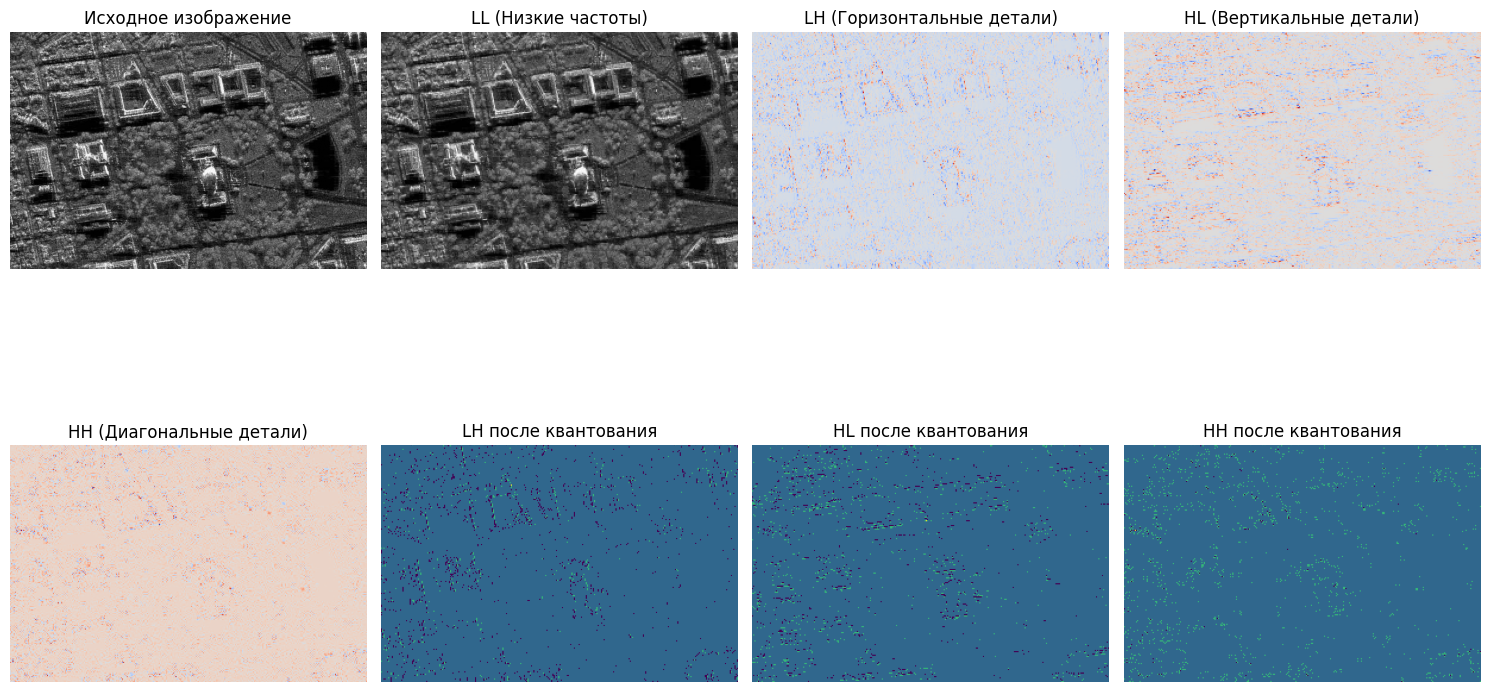

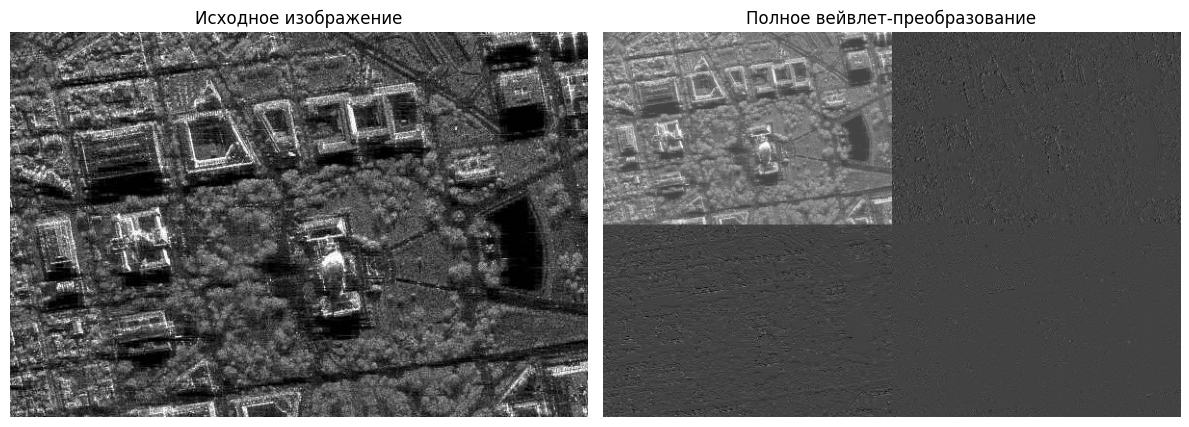


=== РЕЗУЛЬТАТЫ ===
Исходный размер: 765222 байт
Сжатый размер: 235460 байт
Коэффициент сжатия: 3.25
Экономия: 69.2%


In [55]:
main()